# Backtesting Crossover Strategies on Hourly datasets for Ether and BTC

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Backtesting-Crossover-Strategies-on-Hourly-datasets-for-Ether-and-BTC" data-toc-modified-id="Backtesting-Crossover-Strategies-on-Hourly-datasets-for-Ether-and-BTC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Backtesting Crossover Strategies on Hourly datasets for Ether and BTC</a></span><ul class="toc-item"><li><span><a href="#Preparations:" data-toc-modified-id="Preparations:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preparations:</a></span></li></ul></li><li><span><a href="#ETHER" data-toc-modified-id="ETHER-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ETHER</a></span><ul class="toc-item"><li><span><a href="#Download-and-organise-data-from-Binance-(ETH-/-USDT)-1-hour-candles" data-toc-modified-id="Download-and-organise-data-from-Binance-(ETH-/-USDT)-1-hour-candles-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Download and organise data from Binance (ETH / USDT) 1 hour candles</a></span></li><li><span><a href="#Lets-see-how-the-downloaded-data-looks-like" data-toc-modified-id="Lets-see-how-the-downloaded-data-looks-like-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Lets see how the downloaded data looks like</a></span></li><li><span><a href="#Backtest-with-optimised-parameters-for-ETH-/-USDT" data-toc-modified-id="Backtest-with-optimised-parameters-for-ETH-/-USDT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Backtest with optimised parameters for ETH / USDT</a></span></li></ul></li><li><span><a href="#Bitcoin" data-toc-modified-id="Bitcoin-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bitcoin</a></span><ul class="toc-item"><li><span><a href="#Download-and-organise-data-from-Binance-(BTC-/-USDT)-1-hour-candles" data-toc-modified-id="Download-and-organise-data-from-Binance-(BTC-/-USDT)-1-hour-candles-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Download and organise data from Binance (BTC / USDT) 1 hour candles</a></span></li><li><span><a href="#Visualise-BTC-price-data" data-toc-modified-id="Visualise-BTC-price-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualise BTC price data</a></span></li><li><span><a href="#Backtest-with-optimised-parameters-for-simple-EMA-crossover" data-toc-modified-id="Backtest-with-optimised-parameters-for-simple-EMA-crossover-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Backtest with optimised parameters for simple EMA crossover</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Preparations:

In [2]:
# imports
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import matplotlib.pyplot as plt
import pandas as pd

import datetime  # For datetime objects
import pprint
import itertools

import backtrader as bt

from binance.client import Client
from klychi import api_key, api_secret

client = Client(api_key, api_secret)

# to display all of the columns and rows and max width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# to solve issue of bt plot not showing after re-running the cell
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'  # improves the quality of graphs

# set size for plots (width, height)
plt.rcParams['figure.figsize'] = [18, 14]
plt.style.use('ggplot')

In [3]:
def organise_binance_klines(df, save_csv=False, csv_name=''):
    col_names = ['open_time_unix', 'open', 'high', 'low', 'close', 'volume', 
                 'close_time_unix', 'quote_asset_volume', 'number_of_trades', 
                 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df_new = df.copy()
    
    # change unix time to datetime; binance show time in ms
    df_new['candle-start'] = pd.to_datetime(df_new[0], unit='ms')
    df_new['candle-end'] = pd.to_datetime(df_new[6], unit='ms')
    
    # rename columns
    df_new.columns = col_names + ['candle-start', 'candle-end']
    
    # set index and drop extra columns
    df_new.set_index(['candle-end'], inplace=True)
    
    # change dtypes of data from object to float/int
    df_new = df_new.astype({'open': 'float64', 'high': 'float64', 'low': 'float64', 'close': 'float64',
                            'volume': 'float64','quote_asset_volume': 'float64', 'number_of_trades': 'int64',
                            'taker_buy_base_asset_volume': 'float64', 
                            'taker_buy_quote_asset_volume': 'float64'})
    
    if save_csv:
        df_new.to_csv(path_or_buf=str(csv_name) + '.csv')
    
    return df_new


def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total, 2)
    strike_rate = round(number=((total_won / total_closed) * 100), ndigits=2)
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate %','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))


def printDrawDown(analyzer):
    '''
    Function to print the DrawDown results in a nice format.
    '''
    ddpct = round(analyzer.drawdown, 2)
    moneydd = round(analyzer.moneydown, 2)
    ddlen = analyzer.len
    maxdd = round(analyzer.max.drawdown, 2)
    maxmoneydd = round(analyzer.max.moneydown, 2)
    maxddlen = analyzer.max.len
    
    # Designate the rows
    h1 = ['DrawDown %', 'Money Down $', 'DrawDown Length']
    h2 = ['Max DrawDown %','Max MoneyDown $ ', 'Max DrawDown Length']
    r1 = [ddpct, moneydd, ddlen]
    r2 = [maxdd, maxmoneydd, maxddlen]
    
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("DrawDown Results:")
    for row in print_list:
        print(row_format.format('',*row))



# ETHER

## Download and organise data from Binance (ETH / USDT) 1 hour candles

In [4]:
# download data (might take a minute)
# ETH/USDT pair at 1 minute granularity
eth_usdt1m_raw = pd.DataFrame(client.get_historical_klines("ETHUSDT", 
                                                           Client.KLINE_INTERVAL_1MINUTE, 
                                                           '1 Jan 2017'))

In [5]:
# organise eth/usdt data
eth_usdt1m = organise_binance_klines(eth_usdt1m_raw, save_csv=True, csv_name='eth_usdt1m')

# describe downloaded data
eth_usdt1m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1062930 entries, 2017-08-17 04:00:59.999000 to 2019-08-29 11:02:59.999000
Data columns (total 13 columns):
open_time_unix                  1062930 non-null int64
open                            1062930 non-null float64
high                            1062930 non-null float64
low                             1062930 non-null float64
close                           1062930 non-null float64
volume                          1062930 non-null float64
close_time_unix                 1062930 non-null int64
quote_asset_volume              1062930 non-null float64
number_of_trades                1062930 non-null int64
taker_buy_base_asset_volume     1062930 non-null float64
taker_buy_quote_asset_volume    1062930 non-null float64
ignore                          1062930 non-null object
candle-start                    1062930 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 113.5+ MB


In [6]:
eth_usdt1m.head()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,candle-start
candle-end,,,,,,,,,,,,,
2017-08-17 04:00:59.999,1502942400000,301.13,301.13,301.13,301.13,0.42643,1502942459999,128.410866,2,0.42643,128.410866,46530.51064628,2017-08-17 04:00:00
2017-08-17 04:01:59.999,1502942460000,301.13,301.13,301.13,301.13,2.75787,1502942519999,830.477393,4,2.75787,830.477393,46530.51064628,2017-08-17 04:01:00
2017-08-17 04:02:59.999,1502942520000,300.00,300.00,300.00,300.00,0.09930,1502942579999,29.790000,2,0.09930,29.790000,46530.51064628,2017-08-17 04:02:00
2017-08-17 04:03:59.999,1502942580000,300.00,300.00,300.00,300.00,0.31389,1502942639999,94.167000,3,0.00000,0.000000,46530.51064628,2017-08-17 04:03:00
2017-08-17 04:04:59.999,1502942640000,301.13,301.13,301.13,301.13,0.23202,1502942699999,69.868183,1,0.23202,69.868183,46530.96364628,2017-08-17 04:04:00


In [7]:
eth_usdt1m.describe()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06,1.062930e+06
mean,1.535025e+12,3.678704e+02,3.682767e+02,3.674500e+02,3.678653e+02,1.754276e+02,1.535025e+12,4.753169e+04,8.776551e+01,8.959844e+01,2.418515e+04
std,1.851444e+10,2.549711e+02,2.554053e+02,2.545177e+02,2.549684e+02,3.669983e+02,1.851444e+10,8.430286e+04,1.132620e+02,2.003439e+02,4.677611e+04
min,1.502942e+12,8.202000e+01,8.208000e+01,8.179000e+01,8.203000e+01,0.000000e+00,1.502942e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.519047e+12,1.867300e+02,1.868700e+02,1.866000e+02,1.867225e+02,2.434648e+01,1.519047e+12,7.662205e+03,2.900000e+01,9.915795e+00,3.177918e+03
50%,1.535061e+12,2.883000e+02,2.885350e+02,2.880800e+02,2.883100e+02,7.317455e+01,1.535061e+12,2.133514e+04,5.900000e+01,3.475595e+01,9.964810e+03
75%,1.551043e+12,4.719800e+02,4.723900e+02,4.715000e+02,4.719900e+02,1.843329e+02,1.551043e+12,5.308875e+04,1.050000e+02,9.190421e+01,2.593487e+04
max,1.567077e+12,1.433000e+03,1.440000e+03,1.431000e+03,1.433000e+03,2.195220e+04,1.567077e+12,4.353547e+06,4.656000e+03,1.539476e+04,3.773951e+06


## Lets see how the downloaded data looks like

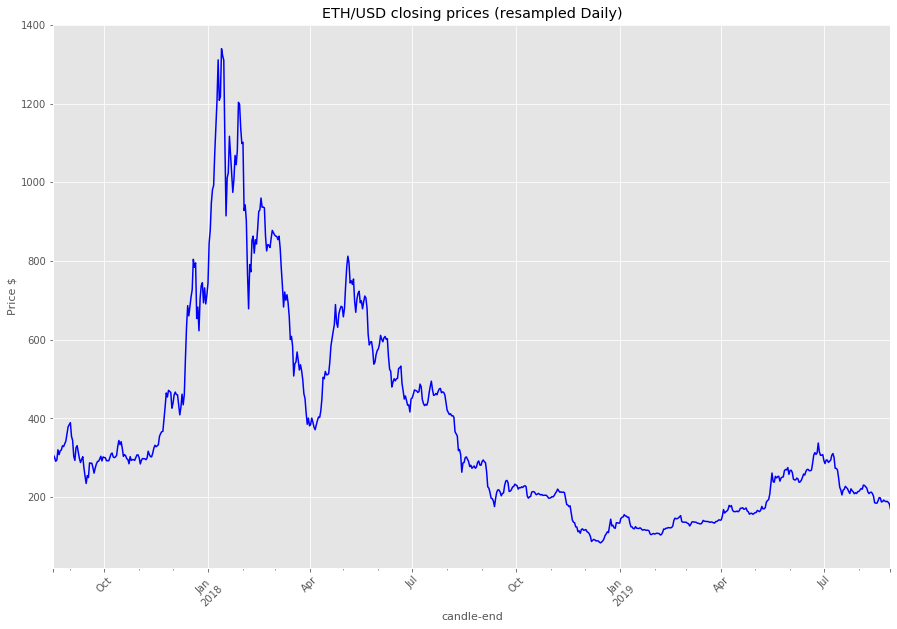

In [8]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot()
ax1.set_xlabel(xlabel='Time', fontsize=11)
ax1.set_ylabel(ylabel='Price $', fontsize=11)

# data is in hourly resolution, so resampling it in daily format to smooth graph
eth_usdt1m['close'].resample('D').mean().plot(ax=ax1, color='blue')

plt.title('ETH/USD closing prices (resampled Daily)')

plt.xticks(rotation=45)

plt.show()

## Backtest with optimised parameters for ETH / USDT

Starting Portfolio Value: 10000.00
2017-08-20T23:16:59.998997, BUY CREATE , 298.39
2017-08-20T23:17:59.999003, BUY EXECUTED, Price: 298.39, Cost: 501.30, Comm 0.50
2017-08-20T23:17:59.999003, TRADE OPENED, SIZE:  1 , VAL: 501.30
2017-09-02T06:10:59.998995, CLOSE LONG , 361.01
2017-09-02T06:10:59.998995, SELL CREATE , 361.01
2017-09-02T06:11:59.999001, SELL EXECUTED, Price: 361.71, Cost: 501.30, Comm 0.79
2017-09-02T06:11:59.999001, SELL EXECUTED, Price: 361.71, Cost: -502.78, Comm 0.50
2017-09-02T06:11:59.999001, OPERATION PROFIT, GROSS 1063.78, NET 1062.49, Acc Balance: 11060.53
2017-09-02T06:11:59.999001, TRADE OPENED, SIZE: -1 , VAL: -502.78
2017-09-06T02:39:59.998995, CLOSE SHORT , 328.89
2017-09-06T02:39:59.998995, BUY CREATE , 328.89
2017-09-06T02:40:59.999001, BUY EXECUTED, Price: 329.00, Cost: -502.78, Comm 0.51
2017-09-06T02:40:59.999001, BUY EXECUTED, Price: 329.00, Cost: 500.08, Comm 0.50
2017-09-06T02:40:59.999001, OPERATION PROFIT, GROSS 454.67, NET 453.65, Acc Balance: 11

2017-10-17T02:06:59.999002, CLOSE LONG , 326.28
2017-10-17T02:06:59.999002, SELL CREATE , 326.28
2017-10-17T02:07:59.998999, SELL EXECUTED, Price: 327.31, Cost: 500.77, Comm 0.49
2017-10-17T02:07:59.998999, SELL EXECUTED, Price: 327.31, Cost: -500.78, Comm 0.50
2017-10-17T02:07:59.998999, OPERATION PROFIT, GROSS -228.93, NET -229.92, Acc Balance: 11035.85
2017-10-17T02:07:59.998999, TRADE OPENED, SIZE: -1 , VAL: -500.78
2017-10-24T06:17:59.999000, CLOSE SHORT , 306.99
2017-10-24T06:17:59.999000, BUY CREATE , 306.99
2017-10-24T06:18:59.998996, BUY EXECUTED, Price: 306.65, Cost: -500.78, Comm 0.57
2017-10-24T06:18:59.998996, BUY EXECUTED, Price: 306.65, Cost: 499.84, Comm 0.50
2017-10-24T06:18:59.998996, OPERATION PROFIT, GROSS 316.10, NET 315.03, Acc Balance: 11352.20
2017-10-24T06:18:59.998996, TRADE OPENED, SIZE:  1 , VAL: 499.84
2017-10-25T11:05:59.998996, CLOSE LONG , 288.54
2017-10-25T11:05:59.998996, SELL CREATE , 288.54
2017-10-25T11:06:59.999002, SELL EXECUTED, Price: 291.61, Co

2017-12-04T17:32:20.808999, CLOSE LONG , 457.00
2017-12-04T17:32:20.808999, SELL CREATE , 457.00
2017-12-04T17:33:20.808995, SELL EXECUTED, Price: 456.81, Cost: 497.66, Comm 0.54
2017-12-04T17:33:20.808995, SELL EXECUTED, Price: 456.81, Cost: -497.92, Comm 0.50
2017-12-04T17:33:20.808995, OPERATION PROFIT, GROSS 48.29, NET 47.25, Acc Balance: 10900.79
2017-12-04T17:33:20.808995, TRADE OPENED, SIZE: -1 , VAL: -497.92
2017-12-05T02:34:20.809002, CLOSE SHORT , 465.50
2017-12-05T02:34:20.809002, BUY CREATE , 465.50
2017-12-05T02:35:20.808998, BUY EXECUTED, Price: 465.05, Cost: -497.92, Comm 0.52
2017-12-05T02:35:20.808998, BUY EXECUTED, Price: 465.05, Cost: 497.60, Comm 0.50
2017-12-05T02:35:20.808998, OPERATION PROFIT, GROSS -89.82, NET -90.83, Acc Balance: 10810.16
2017-12-05T02:35:20.808998, TRADE OPENED, SIZE:  1 , VAL: 497.60
2017-12-05T14:01:20.808999, CLOSE LONG , 452.70
2017-12-05T14:01:20.808999, SELL CREATE , 452.70
2017-12-05T14:02:20.808996, SELL EXECUTED, Price: 452.73, Cost: 

2018-01-26T12:40:59.998998, CLOSE LONG , 1020.99
2018-01-26T12:40:59.998998, SELL CREATE , 1020.99
2018-01-26T12:41:59.999004, SELL EXECUTED, Price: 1021.02, Cost: 499.53, Comm 0.51
2018-01-26T12:41:59.999004, SELL EXECUTED, Price: 1021.02, Cost: -500.30, Comm 0.50
2018-01-26T12:41:59.999004, OPERATION PROFIT, GROSS -196.51, NET -197.51, Acc Balance: 16696.06
2018-01-26T12:41:59.999004, TRADE OPENED, SIZE:  0 , VAL: -500.30
2018-01-26T16:36:59.998999, CLOSE SHORT , 1065.27
2018-01-26T16:36:59.998999, BUY CREATE , 1065.27
2018-01-26T16:37:59.998995, BUY EXECUTED, Price: 1064.99, Cost: -500.30, Comm 0.52
2018-01-26T16:37:59.998995, BUY EXECUTED, Price: 1064.99, Cost: 500.55, Comm 0.50
2018-01-26T16:37:59.998995, OPERATION PROFIT, GROSS -215.45, NET -216.48, Acc Balance: 16471.06
2018-01-26T16:37:59.998995, TRADE OPENED, SIZE:  0 , VAL: 500.55
2018-01-30T05:43:59.999001, CLOSE LONG , 1166.90
2018-01-30T05:43:59.999001, SELL CREATE , 1166.90
2018-01-30T05:44:59.998997, SELL EXECUTED, Price

2018-02-28T23:30:59.998997, CLOSE LONG , 855.70
2018-02-28T23:30:59.998997, SELL CREATE , 855.70
2018-02-28T23:31:59.999003, SELL EXECUTED, Price: 855.70, Cost: 496.03, Comm 0.52
2018-02-28T23:31:59.999003, SELL EXECUTED, Price: 855.70, Cost: -496.31, Comm 0.50
2018-02-28T23:31:59.999003, OPERATION PROFIT, GROSS 2.73, NET 1.71, Acc Balance: 17593.86
2018-02-28T23:31:59.999003, TRADE OPENED, SIZE:  0 , VAL: -496.31
2018-03-01T18:41:59.999004, CLOSE SHORT , 875.90
2018-03-01T18:41:59.999004, BUY CREATE , 875.90
2018-03-01T18:42:59.999001, BUY EXECUTED, Price: 875.90, Cost: -496.31, Comm 0.52
2018-03-01T18:42:59.999001, BUY EXECUTED, Price: 875.90, Cost: 499.26, Comm 0.50
2018-03-01T18:42:59.999001, OPERATION PROFIT, GROSS -117.16, NET -118.18, Acc Balance: 17475.07
2018-03-01T18:42:59.999001, TRADE OPENED, SIZE:  0 , VAL: 499.26
2018-03-02T11:52:59.998999, CLOSE LONG , 859.67
2018-03-02T11:52:59.998999, SELL CREATE , 859.67
2018-03-02T11:53:59.998995, SELL EXECUTED, Price: 859.92, Cost: 

2018-04-17T22:31:59.998997, CLOSE LONG , 505.01
2018-04-17T22:31:59.998997, SELL CREATE , 505.01
2018-04-17T22:32:59.999003, SELL EXECUTED, Price: 505.40, Cost: 501.87, Comm 0.49
2018-04-17T22:32:59.999003, SELL EXECUTED, Price: 505.40, Cost: -500.35, Comm 0.50
2018-04-17T22:32:59.999003, OPERATION PROFIT, GROSS -116.30, NET -117.30, Acc Balance: 19981.76
2018-04-17T22:32:59.999003, TRADE OPENED, SIZE:  0 , VAL: -500.35
2018-04-18T10:02:59.999000, CLOSE SHORT , 514.97
2018-04-18T10:02:59.999000, BUY CREATE , 514.97
2018-04-18T10:03:59.998996, BUY EXECUTED, Price: 514.43, Cost: -500.35, Comm 0.52
2018-04-18T10:03:59.998996, BUY EXECUTED, Price: 514.43, Cost: 499.00, Comm 0.50
2018-04-18T10:03:59.998996, OPERATION PROFIT, GROSS -89.40, NET -90.42, Acc Balance: 19889.90
2018-04-18T10:03:59.998996, TRADE OPENED, SIZE:  0 , VAL: 499.00
2018-04-25T12:14:59.999000, CLOSE LONG , 635.51
2018-04-25T12:14:59.999000, SELL CREATE , 635.51
2018-04-25T12:15:59.998997, SELL EXECUTED, Price: 635.08, Co

2018-06-14T21:17:59.999000, CLOSE SHORT , 517.93
2018-06-14T21:17:59.999000, BUY CREATE , 517.93
2018-06-14T21:18:59.998996, BUY EXECUTED, Price: 517.94, Cost: -499.26, Comm 0.50
2018-06-14T21:18:59.998996, BUY EXECUTED, Price: 517.94, Cost: 502.40, Comm 0.50
2018-06-14T21:18:59.998996, OPERATION PROFIT, GROSS 693.71, NET 692.72, Acc Balance: 22683.95
2018-06-14T21:18:59.998996, TRADE OPENED, SIZE:  0 , VAL: 502.40
2018-06-15T22:32:59.999003, CLOSE LONG , 490.51
2018-06-15T22:32:59.999003, SELL CREATE , 490.51
2018-06-15T22:33:59.998999, SELL EXECUTED, Price: 490.52, Cost: 502.40, Comm 0.49
2018-06-15T22:33:59.998999, SELL EXECUTED, Price: 490.52, Cost: -500.33, Comm 0.50
2018-06-15T22:33:59.998999, OPERATION PROFIT, GROSS -265.97, NET -266.97, Acc Balance: 22419.94
2018-06-15T22:33:59.998999, TRADE OPENED, SIZE: -1 , VAL: -500.33
2018-06-17T00:46:59.998997, CLOSE SHORT , 497.76
2018-06-17T00:46:59.998997, BUY CREATE , 497.76
2018-06-17T00:47:59.999003, BUY EXECUTED, Price: 497.60, Cos

2018-07-27T00:20:59.998999, CLOSE LONG , 463.61
2018-07-27T00:20:59.998999, SELL CREATE , 463.61
2018-07-27T00:21:59.998995, SELL EXECUTED, Price: 463.53, Cost: 501.41, Comm 0.53
2018-07-27T00:21:59.998995, SELL EXECUTED, Price: 463.53, Cost: -500.61, Comm 0.50
2018-07-27T00:21:59.998995, OPERATION PROFIT, GROSS -100.70, NET -101.73, Acc Balance: 22834.31
2018-07-27T00:21:59.998995, TRADE OPENED, SIZE: -1 , VAL: -500.61
2018-08-04T08:06:59.999002, CLOSE SHORT , 417.33
2018-08-04T08:06:59.999002, BUY CREATE , 417.33
2018-08-04T08:07:59.998999, BUY EXECUTED, Price: 417.40, Cost: -500.61, Comm 0.56
2018-08-04T08:07:59.998999, BUY EXECUTED, Price: 417.40, Cost: 500.88, Comm 0.50
2018-08-04T08:07:59.998999, OPERATION PROFIT, GROSS 498.20, NET 497.14, Acc Balance: 23332.52
2018-08-04T08:07:59.998999, TRADE OPENED, SIZE:  1 , VAL: 500.88
2018-08-04T12:06:59.998999, CLOSE LONG , 412.99
2018-08-04T12:06:59.998999, SELL CREATE , 412.99
2018-08-04T12:07:59.998995, SELL EXECUTED, Price: 412.99, Co

2018-08-30T08:22:59.998995, CLOSE LONG , 282.50
2018-08-30T08:22:59.998995, SELL CREATE , 282.50
2018-08-30T08:23:59.999002, SELL EXECUTED, Price: 282.45, Cost: 499.51, Comm 0.55
2018-08-30T08:23:59.999002, SELL EXECUTED, Price: 282.45, Cost: -499.94, Comm 0.50
2018-08-30T08:23:59.999002, OPERATION PROFIT, GROSS 117.29, NET 116.24, Acc Balance: 23460.05
2018-08-30T08:23:59.999002, TRADE OPENED, SIZE: -1 , VAL: -499.94
2018-09-01T03:57:59.998997, CLOSE SHORT , 288.47
2018-09-01T03:57:59.998997, BUY CREATE , 288.47
2018-09-01T03:58:59.999004, BUY EXECUTED, Price: 288.47, Cost: -499.94, Comm 0.54
2018-09-01T03:58:59.999004, BUY EXECUTED, Price: 288.47, Cost: 499.05, Comm 0.50
2018-09-01T03:58:59.999004, OPERATION PROFIT, GROSS -106.55, NET -107.59, Acc Balance: 23350.80
2018-09-01T03:58:59.999004, TRADE OPENED, SIZE:  1 , VAL: 499.05
2018-09-03T10:31:59.998997, CLOSE LONG , 287.02
2018-09-03T10:31:59.998997, SELL CREATE , 287.02
2018-09-03T10:32:59.999003, SELL EXECUTED, Price: 287.02, Co

2018-10-07T09:29:59.998997, CLOSE LONG , 222.90
2018-10-07T09:29:59.998997, SELL CREATE , 222.90
2018-10-07T09:30:59.999004, SELL EXECUTED, Price: 222.90, Cost: 500.79, Comm 0.52
2018-10-07T09:30:59.999004, SELL EXECUTED, Price: 222.90, Cost: -499.30, Comm 0.50
2018-10-07T09:30:59.999004, OPERATION PROFIT, GROSS -37.24, NET -38.27, Acc Balance: 24769.85
2018-10-07T09:30:59.999004, TRADE OPENED, SIZE: -2 , VAL: -499.30
2018-10-08T01:24:59.999001, CLOSE SHORT , 226.20
2018-10-08T01:24:59.999001, BUY CREATE , 226.20
2018-10-08T01:25:59.998998, BUY EXECUTED, Price: 226.20, Cost: -499.30, Comm 0.52
2018-10-08T01:25:59.998998, BUY EXECUTED, Price: 226.20, Cost: 499.90, Comm 0.50
2018-10-08T01:25:59.998998, OPERATION PROFIT, GROSS -73.92, NET -74.94, Acc Balance: 24697.45
2018-10-08T01:25:59.998998, TRADE OPENED, SIZE:  2 , VAL: 499.90
2018-10-10T05:44:59.998997, CLOSE LONG , 224.83
2018-10-10T05:44:59.998997, SELL CREATE , 224.83
2018-10-10T05:45:59.999004, SELL EXECUTED, Price: 224.87, Cost

2018-11-12T16:58:59.999001, CLOSE SHORT , 213.08
2018-11-12T16:58:59.999001, BUY CREATE , 213.08
2018-11-12T16:59:59.998997, BUY EXECUTED, Price: 213.06, Cost: -499.30, Comm 0.51
2018-11-12T16:59:59.998997, BUY EXECUTED, Price: 213.06, Cost: 500.69, Comm 0.50
2018-11-12T16:59:59.998997, OPERATION PROFIT, GROSS -13.87, NET -14.88, Acc Balance: 24336.39
2018-11-12T16:59:59.998997, TRADE OPENED, SIZE:  2 , VAL: 500.69
2018-11-12T17:31:59.999003, CLOSE LONG , 212.27
2018-11-12T17:31:59.999003, SELL CREATE , 212.27
2018-11-12T17:32:59.999000, SELL EXECUTED, Price: 212.19, Cost: 500.69, Comm 0.50
2018-11-12T17:32:59.999000, SELL EXECUTED, Price: 212.19, Cost: -500.77, Comm 0.50
2018-11-12T17:32:59.999000, OPERATION PROFIT, GROSS -20.45, NET -21.44, Acc Balance: 24312.60
2018-11-12T17:32:59.999000, TRADE OPENED, SIZE: -2 , VAL: -500.77
2018-11-28T07:01:59.999003, CLOSE SHORT , 115.91
2018-11-28T07:01:59.999003, BUY CREATE , 115.91
2018-11-28T07:02:59.999000, BUY EXECUTED, Price: 115.92, Cost:

2019-01-06T13:59:59.998997, CLOSE LONG , 150.93
2019-01-06T13:59:59.998997, SELL CREATE , 150.93
2019-01-06T14:00:59.999004, SELL EXECUTED, Price: 150.97, Cost: 500.11, Comm 0.61
2019-01-06T14:00:59.999004, SELL EXECUTED, Price: 150.97, Cost: -499.71, Comm 0.50
2019-01-06T14:00:59.999004, OPERATION PROFIT, GROSS 433.80, NET 432.69, Acc Balance: 28183.03
2019-01-06T14:00:59.999004, TRADE OPENED, SIZE: -3 , VAL: -499.71
2019-01-06T17:31:59.999003, CLOSE SHORT , 155.99
2019-01-06T17:31:59.999003, BUY CREATE , 155.99
2019-01-06T17:32:59.999000, BUY EXECUTED, Price: 155.95, Cost: -499.71, Comm 0.52
2019-01-06T17:32:59.999000, BUY EXECUTED, Price: 155.95, Cost: 500.60, Comm 0.50
2019-01-06T17:32:59.999000, OPERATION PROFIT, GROSS -164.84, NET -165.85, Acc Balance: 28014.15
2019-01-06T17:32:59.999000, TRADE OPENED, SIZE:  3 , VAL: 500.60
2019-01-07T12:58:59.999004, CLOSE LONG , 150.39
2019-01-07T12:58:59.999004, SELL CREATE , 150.39
2019-01-07T12:59:59.999000, SELL EXECUTED, Price: 150.38, Co

2019-02-15T17:56:59.999004, CLOSE LONG , 121.26
2019-02-15T17:56:59.999004, SELL CREATE , 121.26
2019-02-15T17:57:59.999001, SELL EXECUTED, Price: 121.20, Cost: 500.29, Comm 0.49
2019-02-15T17:57:59.999001, SELL EXECUTED, Price: 121.20, Cost: -499.34, Comm 0.50
2019-02-15T17:57:59.999001, OPERATION PROFIT, GROSS -57.94, NET -58.93, Acc Balance: 28244.92
2019-02-15T17:57:59.999001, TRADE OPENED, SIZE: -4 , VAL: -499.34
2019-02-16T04:15:59.999004, CLOSE SHORT , 122.61
2019-02-16T04:15:59.999004, BUY CREATE , 122.61
2019-02-16T04:16:59.999000, BUY EXECUTED, Price: 122.59, Cost: -499.34, Comm 0.52
2019-02-16T04:16:59.999000, BUY EXECUTED, Price: 122.59, Cost: 500.17, Comm 0.50
2019-02-16T04:16:59.999000, OPERATION PROFIT, GROSS -57.27, NET -58.29, Acc Balance: 28186.38
2019-02-16T04:16:59.999000, TRADE OPENED, SIZE:  4 , VAL: 500.17
2019-02-24T18:46:59.998997, CLOSE LONG , 139.42
2019-02-24T18:46:59.998997, SELL CREATE , 139.42
2019-02-24T18:47:59.999003, SELL EXECUTED, Price: 139.43, Cost

2019-04-15T19:02:59.999000, CLOSE LONG , 160.27
2019-04-15T19:02:59.999000, SELL CREATE , 160.27
2019-04-15T19:03:59.998996, SELL EXECUTED, Price: 160.24, Cost: 500.10, Comm 0.49
2019-04-15T19:03:59.998996, SELL EXECUTED, Price: 160.24, Cost: -499.95, Comm 0.50
2019-04-15T19:03:59.998996, OPERATION PROFIT, GROSS -193.80, NET -194.79, Acc Balance: 28813.66
2019-04-15T19:03:59.998996, TRADE OPENED, SIZE: -3 , VAL: -499.95
2019-04-16T22:04:59.999003, CLOSE SHORT , 164.94
2019-04-16T22:04:59.999003, BUY CREATE , 164.94
2019-04-16T22:05:59.998999, BUY EXECUTED, Price: 164.92, Cost: -499.95, Comm 0.53
2019-04-16T22:05:59.998999, BUY EXECUTED, Price: 164.92, Cost: 499.71, Comm 0.50
2019-04-16T22:05:59.998999, OPERATION PROFIT, GROSS -146.02, NET -147.04, Acc Balance: 28667.88
2019-04-16T22:05:59.998999, TRADE OPENED, SIZE:  3 , VAL: 499.71
2019-04-21T09:22:59.999002, CLOSE LONG , 169.61
2019-04-21T09:22:59.999002, SELL CREATE , 169.61
2019-04-21T09:23:59.998998, SELL EXECUTED, Price: 169.61, 

2019-05-22T22:05:59.998999, CLOSE LONG , 240.10
2019-05-22T22:05:59.998999, SELL CREATE , 240.10
2019-05-22T22:06:59.998995, SELL EXECUTED, Price: 240.42, Cost: 499.89, Comm 0.52
2019-05-22T22:06:59.998995, SELL EXECUTED, Price: 240.42, Cost: -500.07, Comm 0.50
2019-05-22T22:06:59.998995, OPERATION PROFIT, GROSS -214.52, NET -215.54, Acc Balance: 29670.57
2019-05-22T22:06:59.998995, TRADE OPENED, SIZE: -2 , VAL: -500.07
2019-05-24T11:57:59.999001, CLOSE SHORT , 251.27
2019-05-24T11:57:59.999001, BUY CREATE , 251.27
2019-05-24T11:58:59.998997, BUY EXECUTED, Price: 251.23, Cost: -500.07, Comm 0.55
2019-05-24T11:58:59.998997, BUY EXECUTED, Price: 251.23, Cost: 499.95, Comm 0.50
2019-05-24T11:58:59.998997, OPERATION PROFIT, GROSS -224.85, NET -225.90, Acc Balance: 29450.13
2019-05-24T11:58:59.998997, TRADE OPENED, SIZE:  1 , VAL: 499.95
2019-05-26T10:31:59.998997, CLOSE LONG , 247.26
2019-05-26T10:31:59.998997, SELL CREATE , 247.26
2019-05-26T10:32:59.999003, SELL EXECUTED, Price: 247.30, 

2019-07-10T15:31:59.999000, CLOSE LONG , 288.06
2019-07-10T15:31:59.999000, SELL CREATE , 288.06
2019-07-10T15:32:59.998996, SELL EXECUTED, Price: 288.06, Cost: 499.66, Comm 0.53
2019-07-10T15:32:59.998996, SELL EXECUTED, Price: 288.06, Cost: -501.22, Comm 0.50
2019-07-10T15:32:59.998996, OPERATION PROFIT, GROSS -70.79, NET -71.83, Acc Balance: 28868.79
2019-07-10T15:32:59.998996, TRADE OPENED, SIZE: -1 , VAL: -501.22
2019-07-18T16:09:59.998995, CLOSE SHORT , 223.66
2019-07-18T16:09:59.998995, BUY CREATE , 223.66
2019-07-18T16:10:59.999001, BUY EXECUTED, Price: 223.66, Cost: -501.22, Comm 0.50
2019-07-18T16:10:59.999001, BUY EXECUTED, Price: 223.66, Cost: 501.00, Comm 0.50
2019-07-18T16:10:59.999001, OPERATION PROFIT, GROSS 1120.56, NET 1119.56, Acc Balance: 30028.03
2019-07-18T16:10:59.999001, TRADE OPENED, SIZE:  2 , VAL: 501.00
2019-07-21T18:03:59.998999, CLOSE LONG , 218.84
2019-07-21T18:03:59.998999, SELL CREATE , 218.84
2019-07-21T18:04:59.998996, SELL EXECUTED, Price: 218.85, Co


Final Portfolio Value: 29513.54

Annualised SharpeR: 1.1239165790665975

CAGR %  71.7950401041695

Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               1              327            98             229            
               Strike Rate %  Win Streak     Losing Streak  PnL Net        
               29.97          3              10             19462.43       

DrawDown Results:
               DrawDown %     Money Down $   DrawDown Length
               5.21           1621.72        150352         
               Max DrawDown % Max MoneyDown $ Max DrawDown Length
               21.29          2567.06        203367         

{'all': AutoOrderedDict([('firstStrategyTradingDate',
                          datetime.datetime(2017, 8, 19, 6, 0, 59, 999000)),
                         ('lastStrategyTradingDate',
                          datetime.datetime(2019, 8, 29, 11, 2, 59, 998996)),
                         ('trades',
     

<IPython.core.display.Javascript object>


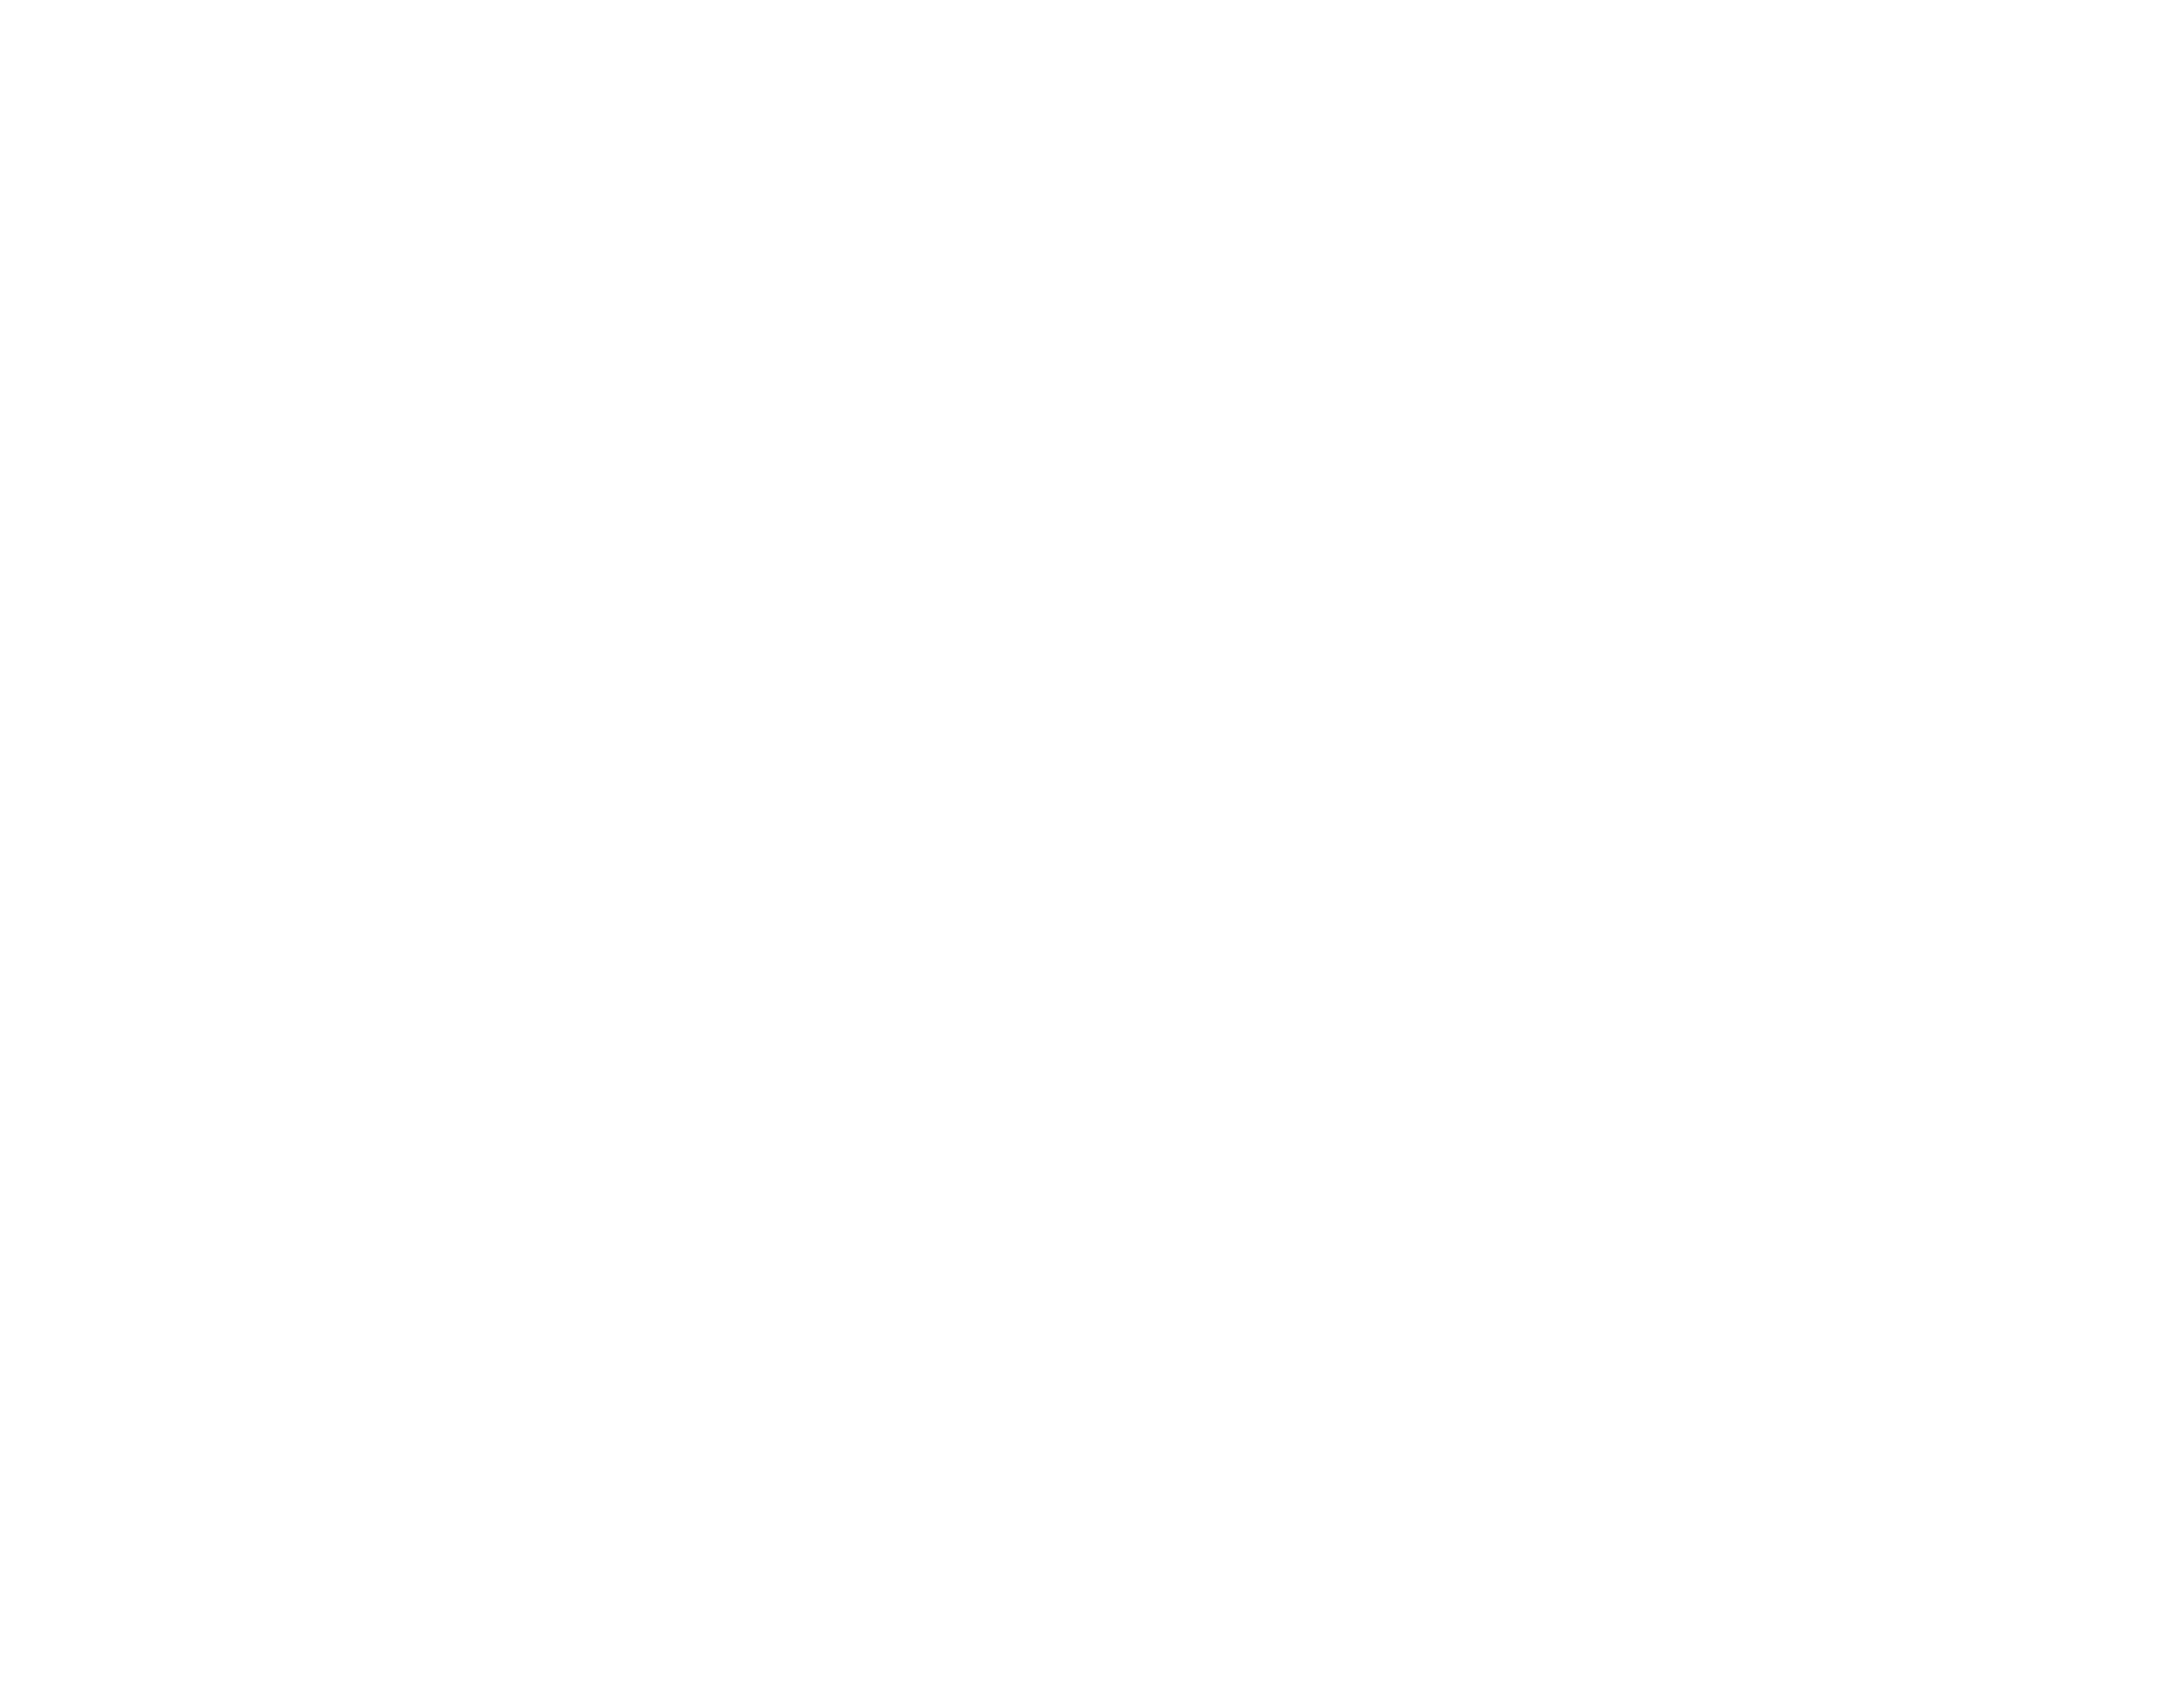

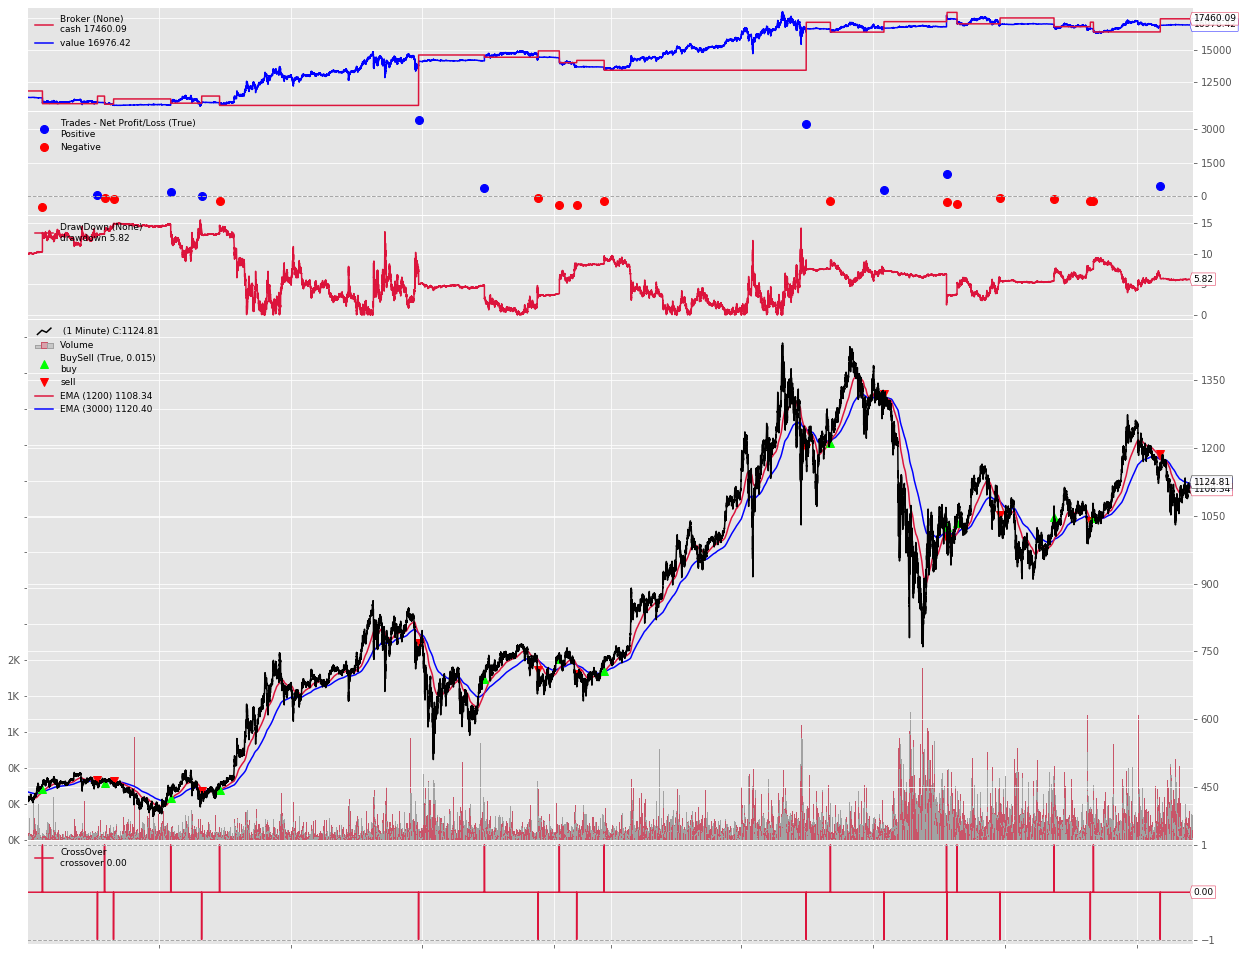

In [24]:
# Backtest with optimised parameters on ETH/USD

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 1200),  # 20 hours
        ('long_ema', 3000),  # 50 hours
        ('mult', 10),
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=eth_usdt1m,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=1)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = ((end bal / beg bal) ^ 1/n of years - 1) * 100
    print('CAGR % ', ((cerebro.broker.getvalue() / 10000) ** 0.5 - 1) * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 2, 1))
    
    # cerebro.plot()  # plot backtest



# Bitcoin

## Download and organise data from Binance (BTC / USDT) 1 hour candles

In [9]:
# download data (might take a minute)
# BTC/USDT pair at 1 hour granularity
btc_usdt1m_raw = pd.DataFrame(client.get_historical_klines("BTCUSDT", 
                                                           Client.KLINE_INTERVAL_1MINUTE, 
                                                           '1 Jan 2017'))

In [10]:
# organise btc/usdt data
btc_usdt1m = organise_binance_klines(btc_usdt1m_raw, save_csv=True, csv_name='btc_usdt1m')

# describe downloaded data
btc_usdt1m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1062966 entries, 2017-08-17 04:00:59.999000 to 2019-08-29 11:38:59.999000
Data columns (total 13 columns):
open_time_unix                  1062966 non-null int64
open                            1062966 non-null float64
high                            1062966 non-null float64
low                             1062966 non-null float64
close                           1062966 non-null float64
volume                          1062966 non-null float64
close_time_unix                 1062966 non-null int64
quote_asset_volume              1062966 non-null float64
number_of_trades                1062966 non-null int64
taker_buy_base_asset_volume     1062966 non-null float64
taker_buy_quote_asset_volume    1062966 non-null float64
ignore                          1062966 non-null object
candle-start                    1062966 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 113.5+ MB


In [11]:
btc_usdt1m.head()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,candle-start
candle-end,,,,,,,,,,,,,
2017-08-17 04:00:59.999,1502942400000,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7564.906851,3,0.075183,320.390851,7960.54017996,2017-08-17 04:00:00
2017-08-17 04:01:59.999,1502942460000,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000,0,0.000000,0.000000,7960.45262989,2017-08-17 04:01:00
2017-08-17 04:02:59.999,1502942520000,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1117.542921,2,0.261074,1117.542921,7960.37529526,2017-08-17 04:02:00
2017-08-17 04:03:59.999,1502942580000,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,51.171852,3,0.012008,51.171852,7960.37529526,2017-08-17 04:03:00
2017-08-17 04:04:59.999,1502942640000,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,599.999338,1,0.140796,599.999338,7960.37529526,2017-08-17 04:04:00


In [12]:
btc_usdt1m.describe()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06,1.062966e+06
mean,1.535026e+12,7.301306e+03,7.307742e+03,7.294584e+03,7.301277e+03,2.239322e+01,1.535026e+12,1.685981e+05,1.638579e+02,1.152244e+01,8.643098e+04
std,1.851507e+10,3.035453e+03,3.040989e+03,3.029685e+03,3.035467e+03,3.708723e+01,1.851507e+10,3.113797e+05,2.183580e+02,1.960270e+01,1.632671e+05
min,1.502942e+12,2.830000e+03,2.830000e+03,2.817000e+03,2.817000e+03,0.000000e+00,1.502942e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.519048e+12,4.700000e+03,4.702040e+03,4.697132e+03,4.699990e+03,5.396216e+00,1.519048e+12,3.362008e+04,6.300000e+01,2.486766e+00,1.560866e+04
50%,1.535062e+12,6.690000e+03,6.693685e+03,6.686345e+03,6.690000e+03,1.265179e+01,1.535062e+12,8.639879e+04,1.110000e+02,6.224799e+00,4.213846e+04
75%,1.551044e+12,8.987227e+03,8.996000e+03,8.977007e+03,8.987000e+03,2.591722e+01,1.551044e+12,1.934012e+05,1.910000e+02,1.331420e+01,9.890776e+04
max,1.567079e+12,1.976204e+04,1.979868e+04,1.974900e+04,1.977074e+04,1.827534e+03,1.567079e+12,2.369937e+07,1.376900e+04,1.538383e+03,1.862433e+07


## Visualise BTC price data

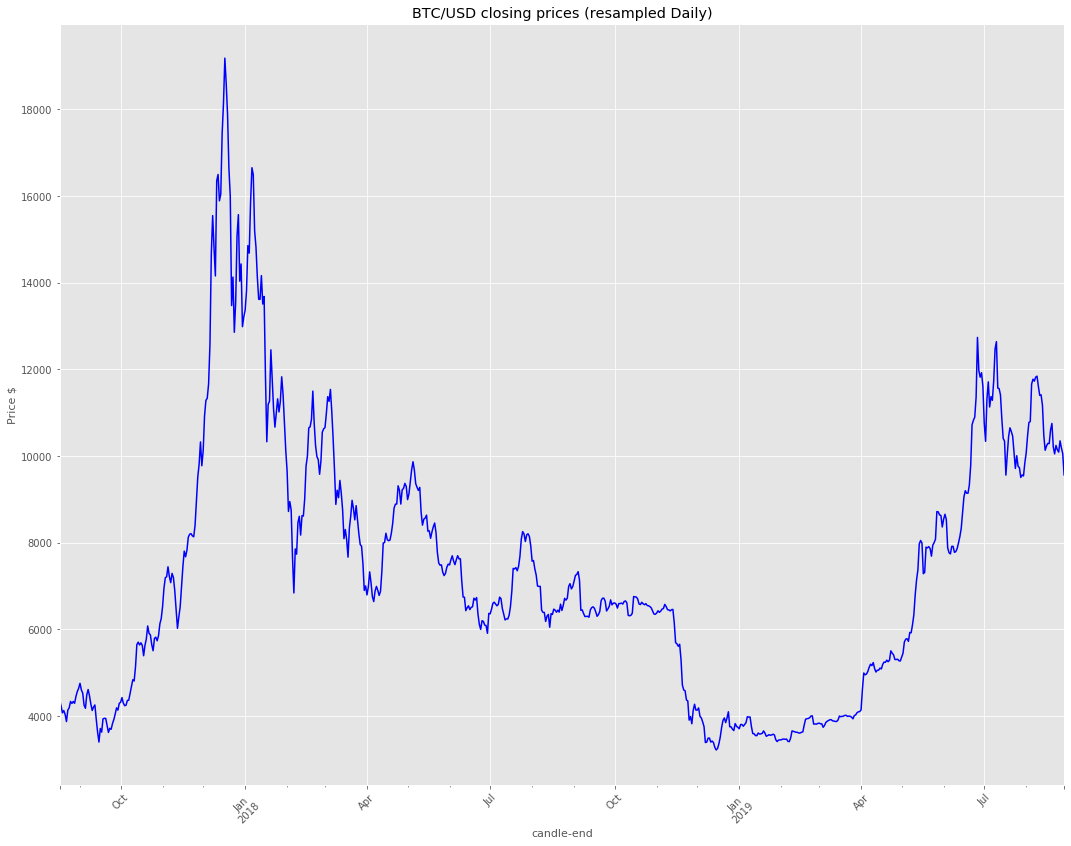

In [13]:
fig = plt.figure(figsize=(18, 14))

ax1 = fig.add_subplot()
ax1.set_xlabel(xlabel='Time', fontsize=11)
ax1.set_ylabel(ylabel='Price $', fontsize=11)

# data is in hourly resolution, so resampling it in daily format to smooth graph
btc_usdt1m['close'].resample('D').mean().plot(ax=ax1, color='blue')

plt.title('BTC/USD closing prices (resampled Daily)')

plt.xticks(rotation=45)

plt.show()

## Backtest with optimised parameters for simple EMA crossover

Starting Portfolio Value: 10000.00
2017-08-23T02:12:59.999001, BUY CREATE , 4103.52
2017-08-23T02:13:59.998997, BUY EXECUTED, Price: 4103.52, Cost: 492.42, Comm 0.49
2017-08-23T02:13:59.998997, TRADE OPENED, SIZE:  0 , VAL: 492.42
2017-08-28T04:32:59.999003, CLOSE LONG , 4131.26
2017-08-28T04:32:59.999003, SELL CREATE , 4131.26
2017-08-28T04:33:59.998999, SELL EXECUTED, Price: 4189.97, Cost: 492.42, Comm 0.57
2017-08-28T04:33:59.998999, SELL EXECUTED, Price: 4189.97, Cost: -502.80, Comm 0.50
2017-08-28T04:33:59.998999, OPERATION PROFIT, GROSS 103.74, NET 102.68, Acc Balance: 10102.17
2017-08-28T04:33:59.998999, TRADE OPENED, SIZE:  0 , VAL: -502.80
2017-08-28T18:30:59.999004, CLOSE SHORT , 4323.32
2017-08-28T18:30:59.999004, BUY CREATE , 4323.32
2017-08-28T18:31:59.999000, BUY EXECUTED, Price: 4323.32, Cost: -502.80, Comm 0.52
2017-08-28T18:31:59.999000, BUY EXECUTED, Price: 4323.32, Cost: 518.80, Comm 0.52
2017-08-28T18:31:59.999000, OPERATION PROFIT, GROSS -160.02, NET -161.04, Acc B

2017-10-17T12:09:59.998998, CLOSE LONG , 5532.47
2017-10-17T12:09:59.998998, SELL CREATE , 5532.47
2017-10-17T12:10:59.998995, SELL EXECUTED, Price: 5532.45, Cost: 512.65, Comm 0.51
2017-10-17T12:10:59.998995, SELL EXECUTED, Price: 5532.45, Cost: -497.92, Comm 0.50
2017-10-17T12:10:59.998995, OPERATION PROFIT, GROSS -147.28, NET -148.30, Acc Balance: 11851.63
2017-10-17T12:10:59.998995, TRADE OPENED, SIZE:  0 , VAL: -497.92
2017-10-19T06:02:59.999003, CLOSE SHORT , 5580.00
2017-10-19T06:02:59.999003, BUY CREATE , 5580.00
2017-10-19T06:03:59.998999, BUY EXECUTED, Price: 5580.01, Cost: -497.92, Comm 0.53
2017-10-19T06:03:59.998999, BUY EXECUTED, Price: 5580.01, Cost: 502.20, Comm 0.50
2017-10-19T06:03:59.998999, OPERATION PROFIT, GROSS -42.80, NET -43.83, Acc Balance: 11809.37
2017-10-19T06:03:59.998999, TRADE OPENED, SIZE:  0 , VAL: 502.20
2017-10-22T11:13:59.998997, CLOSE LONG , 5729.48
2017-10-22T11:13:59.998997, SELL CREATE , 5729.48
2017-10-22T11:14:59.999004, SELL EXECUTED, Price: 

2017-11-30T12:24:59.998995, CLOSE LONG , 9650.00
2017-11-30T12:24:59.998995, SELL CREATE , 9650.00
2017-11-30T12:25:59.999001, SELL EXECUTED, Price: 9649.98, Cost: 491.10, Comm 0.66
2017-11-30T12:25:59.999001, SELL EXECUTED, Price: 9649.98, Cost: -482.50, Comm 0.48
2017-11-30T12:25:59.999001, OPERATION PROFIT, GROSS 879.01, NET 877.86, Acc Balance: 14735.45
2017-11-30T12:25:59.999001, TRADE OPENED, SIZE:  0 , VAL: -482.50
2017-12-01T13:36:59.998999, CLOSE SHORT , 10499.00
2017-12-01T13:36:59.998999, BUY CREATE , 10499.00
2017-12-01T13:37:59.998995, BUY EXECUTED, Price: 10499.00, Cost: -482.50, Comm 0.54
2017-12-01T13:37:59.998995, BUY EXECUTED, Price: 10499.00, Cost: 524.95, Comm 0.52
2017-12-01T13:37:59.998995, OPERATION PROFIT, GROSS -424.51, NET -425.53, Acc Balance: 14308.55
2017-12-01T13:37:59.998995, TRADE OPENED, SIZE:  0 , VAL: 524.95
2017-12-09T16:37:20.798001, CLOSE LONG , 13999.96
2017-12-09T16:37:20.798001, SELL CREATE , 13999.96
2017-12-09T16:38:20.797997, SELL EXECUTED, P

2018-01-14T08:26:59.999001, CLOSE LONG , 13699.00
2018-01-14T08:26:59.999001, SELL CREATE , 13699.00
2018-01-14T08:27:59.998997, SELL EXECUTED, Price: 13699.00, Cost: 559.32, Comm 0.56
2018-01-14T08:27:59.998997, SELL EXECUTED, Price: 13699.00, Cost: -547.96, Comm 0.55
2018-01-14T08:27:59.998997, OPERATION PROFIT, GROSS -113.58, NET -114.71, Acc Balance: 16967.55
2018-01-14T08:27:59.998997, TRADE OPENED, SIZE:  0 , VAL: -547.96
2018-01-15T14:51:59.999002, CLOSE SHORT , 14140.56
2018-01-15T14:51:59.999002, BUY CREATE , 14140.56
2018-01-15T14:52:59.998999, BUY EXECUTED, Price: 14140.56, Cost: -547.96, Comm 0.58
2018-01-15T14:52:59.998999, BUY EXECUTED, Price: 14140.56, Cost: 565.62, Comm 0.57
2018-01-15T14:52:59.998999, OPERATION PROFIT, GROSS -176.62, NET -177.75, Acc Balance: 16789.75
2018-01-15T14:52:59.998999, TRADE OPENED, SIZE:  0 , VAL: 565.62
2018-01-16T00:54:59.998998, CLOSE LONG , 13249.26
2018-01-16T00:54:59.998998, SELL CREATE , 13249.26
2018-01-16T00:55:59.998995, SELL EXECU

2018-03-01T04:37:59.998995, CLOSE LONG , 10440.70
2018-03-01T04:37:59.998995, SELL CREATE , 10440.70
2018-03-01T04:38:59.999002, SELL EXECUTED, Price: 10440.70, Cost: 508.50, Comm 0.56
2018-03-01T04:38:59.999002, SELL EXECUTED, Price: 10440.70, Cost: -522.04, Comm 0.52
2018-03-01T04:38:59.999002, OPERATION PROFIT, GROSS 135.35, NET 134.28, Acc Balance: 18632.41
2018-03-01T04:38:59.999002, TRADE OPENED, SIZE:  0 , VAL: -522.04
2018-03-01T08:25:59.998995, CLOSE SHORT , 10642.71
2018-03-01T08:25:59.998995, BUY CREATE , 10642.71
2018-03-01T08:26:59.999001, BUY EXECUTED, Price: 10636.90, Cost: -522.04, Comm 0.53
2018-03-01T08:26:59.999001, BUY EXECUTED, Price: 10636.90, Cost: 531.85, Comm 0.53
2018-03-01T08:26:59.999001, OPERATION PROFIT, GROSS -98.10, NET -99.15, Acc Balance: 18529.93
2018-03-01T08:26:59.999001, TRADE OPENED, SIZE:  0 , VAL: 531.85
2018-03-06T07:35:59.999002, CLOSE LONG , 11256.70
2018-03-06T07:35:59.999002, SELL CREATE , 11256.70
2018-03-06T07:36:59.998999, SELL EXECUTED,

2018-04-25T15:46:59.998997, CLOSE LONG , 8943.00
2018-04-25T15:46:59.998997, SELL CREATE , 8943.00
2018-04-25T15:47:59.999003, SELL EXECUTED, Price: 8950.00, Cost: 486.00, Comm 0.63
2018-04-25T15:47:59.999003, SELL EXECUTED, Price: 8950.00, Cost: -537.00, Comm 0.54
2018-04-25T15:47:59.999003, OPERATION PROFIT, GROSS 510.00, NET 508.88, Acc Balance: 20446.83
2018-04-25T15:47:59.999003, TRADE OPENED, SIZE:  0 , VAL: -537.00
2018-04-27T01:11:59.998998, CLOSE SHORT , 9235.00
2018-04-27T01:11:59.998998, BUY CREATE , 9235.00
2018-04-27T01:12:59.999004, BUY EXECUTED, Price: 9235.00, Cost: -537.00, Comm 0.58
2018-04-27T01:12:59.999004, BUY EXECUTED, Price: 9235.00, Cost: 461.75, Comm 0.46
2018-04-27T01:12:59.999004, OPERATION PROFIT, GROSS -171.00, NET -172.12, Acc Balance: 20279.73
2018-04-27T01:12:59.999004, TRADE OPENED, SIZE:  0 , VAL: 461.75
2018-04-30T09:52:59.998995, CLOSE LONG , 9195.00
2018-04-30T09:52:59.998995, SELL CREATE , 9195.00
2018-04-30T09:53:59.999002, SELL EXECUTED, Price: 

2018-06-04T11:29:59.999000, CLOSE LONG , 7532.00
2018-06-04T11:29:59.999000, SELL CREATE , 7532.00
2018-06-04T11:30:59.998997, SELL EXECUTED, Price: 7532.00, Cost: 527.24, Comm 0.56
2018-06-04T11:30:59.998997, SELL EXECUTED, Price: 7532.00, Cost: -527.24, Comm 0.53
2018-06-04T11:30:59.998997, OPERATION PROFIT, GROSS -0.01, NET -1.09, Acc Balance: 20413.24
2018-06-04T11:30:59.998997, TRADE OPENED, SIZE:  0 , VAL: -527.24
2018-06-05T22:16:59.999000, CLOSE SHORT , 7604.95
2018-06-05T22:16:59.999000, BUY CREATE , 7604.95
2018-06-05T22:17:59.998996, BUY EXECUTED, Price: 7604.09, Cost: -527.24, Comm 0.55
2018-06-05T22:17:59.998996, BUY EXECUTED, Price: 7604.09, Cost: 532.29, Comm 0.53
2018-06-05T22:17:59.998996, OPERATION PROFIT, GROSS -50.46, NET -51.54, Acc Balance: 20362.19
2018-06-05T22:17:59.998996, TRADE OPENED, SIZE:  0 , VAL: 532.29
2018-06-08T10:39:59.998998, CLOSE LONG , 7562.90
2018-06-08T10:39:59.998998, SELL CREATE , 7562.90
2018-06-08T10:40:59.998995, SELL EXECUTED, Price: 7562

2018-07-21T01:49:59.999003, CLOSE LONG , 7254.07
2018-07-21T01:49:59.999003, SELL CREATE , 7254.07
2018-07-21T01:50:59.998999, SELL EXECUTED, Price: 7257.99, Cost: 501.47, Comm 0.68
2018-07-21T01:50:59.998999, SELL EXECUTED, Price: 7257.99, Cost: -508.06, Comm 0.51
2018-07-21T01:50:59.998999, OPERATION PROFIT, GROSS 791.70, NET 790.53, Acc Balance: 21383.64
2018-07-21T01:50:59.998999, TRADE OPENED, SIZE:  0 , VAL: -508.06
2018-07-21T17:56:59.999004, CLOSE SHORT , 7413.99
2018-07-21T17:56:59.999004, BUY CREATE , 7413.99
2018-07-21T17:57:59.999001, BUY EXECUTED, Price: 7409.81, Cost: -508.06, Comm 0.52
2018-07-21T17:57:59.999001, BUY EXECUTED, Price: 7409.81, Cost: 518.69, Comm 0.52
2018-07-21T17:57:59.999001, OPERATION PROFIT, GROSS -106.27, NET -107.30, Acc Balance: 21281.07
2018-07-21T17:57:59.999001, TRADE OPENED, SIZE:  0 , VAL: 518.69
2018-07-26T23:29:59.999000, CLOSE LONG , 7899.86
2018-07-26T23:29:59.999000, SELL CREATE , 7899.86
2018-07-26T23:30:59.998997, SELL EXECUTED, Price: 

2018-09-05T11:41:59.998998, CLOSE LONG , 6970.99
2018-09-05T11:41:59.998998, SELL CREATE , 6970.99
2018-09-05T11:42:59.999004, SELL EXECUTED, Price: 6970.70, Cost: 488.56, Comm 0.55
2018-09-05T11:42:59.999004, SELL EXECUTED, Price: 6970.70, Cost: -487.95, Comm 0.49
2018-09-05T11:42:59.999004, OPERATION PROFIT, GROSS -6.12, NET -7.16, Acc Balance: 21353.12
2018-09-05T11:42:59.999004, TRADE OPENED, SIZE:  0 , VAL: -487.95
2018-09-11T06:38:59.998995, CLOSE SHORT , 6351.00
2018-09-11T06:38:59.998995, BUY CREATE , 6351.00
2018-09-11T06:39:59.999001, BUY EXECUTED, Price: 6351.25, Cost: -487.95, Comm 0.52
2018-09-11T06:39:59.999001, BUY EXECUTED, Price: 6351.25, Cost: 508.10, Comm 0.51
2018-09-11T06:39:59.999001, OPERATION PROFIT, GROSS 433.61, NET 432.60, Acc Balance: 21785.00
2018-09-11T06:39:59.999001, TRADE OPENED, SIZE:  0 , VAL: 508.10
2018-09-11T11:35:59.998999, CLOSE LONG , 6263.87
2018-09-11T11:35:59.998999, SELL CREATE , 6263.87
2018-09-11T11:36:59.998995, SELL EXECUTED, Price: 6262

2018-10-02T09:53:59.999002, CLOSE LONG , 6587.56
2018-10-02T09:53:59.999002, SELL CREATE , 6587.56
2018-10-02T09:54:59.998998, SELL EXECUTED, Price: 6586.22, Cost: 529.35, Comm 0.53
2018-10-02T09:54:59.998998, SELL EXECUTED, Price: 6586.22, Cost: -526.90, Comm 0.53
2018-10-02T09:54:59.998998, OPERATION PROFIT, GROSS -24.53, NET -25.58, Acc Balance: 21566.17
2018-10-02T09:54:59.998998, TRADE OPENED, SIZE:  0 , VAL: -526.90
2018-10-04T04:40:59.998995, CLOSE SHORT , 6600.91
2018-10-04T04:40:59.998995, BUY CREATE , 6600.91
2018-10-04T04:41:59.999001, BUY EXECUTED, Price: 6601.92, Cost: -526.90, Comm 0.56
2018-10-04T04:41:59.999001, BUY EXECUTED, Price: 6601.92, Cost: 528.15, Comm 0.53
2018-10-04T04:41:59.999001, OPERATION PROFIT, GROSS -12.56, NET -13.64, Acc Balance: 21552.41
2018-10-04T04:41:59.999001, TRADE OPENED, SIZE:  0 , VAL: 528.15
2018-10-07T08:01:59.999000, CLOSE LONG , 6571.98
2018-10-07T08:01:59.999000, SELL CREATE , 6571.98
2018-10-07T08:02:59.998996, SELL EXECUTED, Price: 65

2018-11-14T11:22:59.998995, CLOSE LONG , 6362.66
2018-11-14T11:22:59.998995, SELL CREATE , 6362.66
2018-11-14T11:23:59.999002, SELL EXECUTED, Price: 6362.45, Cost: 516.93, Comm 0.52
2018-11-14T11:23:59.999002, SELL EXECUTED, Price: 6362.45, Cost: -509.00, Comm 0.51
2018-11-14T11:23:59.999002, OPERATION PROFIT, GROSS -79.35, NET -80.39, Acc Balance: 21826.45
2018-11-14T11:23:59.999002, TRADE OPENED, SIZE:  0 , VAL: -509.00
2018-11-28T06:06:59.998999, CLOSE SHORT , 4075.00
2018-11-28T06:06:59.998999, BUY CREATE , 4075.00
2018-11-28T06:07:59.998995, BUY EXECUTED, Price: 4075.00, Cost: -509.00, Comm 0.52
2018-11-28T06:07:59.998995, BUY EXECUTED, Price: 4075.00, Cost: 489.00, Comm 0.49
2018-11-28T06:07:59.998995, OPERATION PROFIT, GROSS 1829.96, NET 1828.93, Acc Balance: 23655.77
2018-11-28T06:07:59.998995, TRADE OPENED, SIZE:  0 , VAL: 489.00
2018-11-30T12:59:59.999000, CLOSE LONG , 4025.99
2018-11-30T12:59:59.999000, SELL CREATE , 4025.99
2018-11-30T13:00:59.998997, SELL EXECUTED, Price: 

2019-01-06T04:01:59.999003, CLOSE LONG , 3770.02
2019-01-06T04:01:59.999003, SELL CREATE , 3770.02
2019-01-06T04:02:59.999000, SELL EXECUTED, Price: 3770.03, Cost: 495.68, Comm 0.50
2019-01-06T04:02:59.999000, SELL EXECUTED, Price: 3770.03, Cost: -490.10, Comm 0.49
2019-01-06T04:02:59.999000, OPERATION PROFIT, GROSS -55.81, NET -56.81, Acc Balance: 23281.54
2019-01-06T04:02:59.999000, TRADE OPENED, SIZE:  0 , VAL: -490.10
2019-01-06T12:56:59.999001, CLOSE SHORT , 3794.22
2019-01-06T12:56:59.999001, BUY CREATE , 3794.22
2019-01-06T12:57:59.998997, BUY EXECUTED, Price: 3794.70, Cost: -490.10, Comm 0.49
2019-01-06T12:57:59.998997, BUY EXECUTED, Price: 3794.70, Cost: 493.31, Comm 0.49
2019-01-06T12:57:59.998997, OPERATION PROFIT, GROSS -32.07, NET -33.05, Acc Balance: 23246.94
2019-01-06T12:57:59.998997, TRADE OPENED, SIZE:  0 , VAL: 493.31
2019-01-10T06:59:59.999000, CLOSE LONG , 3781.31
2019-01-10T06:59:59.999000, SELL CREATE , 3781.31
2019-01-10T07:00:59.998997, SELL EXECUTED, Price: 37

2019-02-06T01:19:59.998999, CLOSE LONG , 3423.61
2019-02-06T01:19:59.998999, SELL CREATE , 3423.61
2019-02-06T01:20:59.998996, SELL EXECUTED, Price: 3423.53, Cost: 485.72, Comm 0.51
2019-02-06T01:20:59.998996, SELL EXECUTED, Price: 3423.53, Cost: -513.53, Comm 0.51
2019-02-06T01:20:59.998996, OPERATION PROFIT, GROSS -64.26, NET -65.25, Acc Balance: 22608.33
2019-02-06T01:20:59.998996, TRADE OPENED, SIZE:  0 , VAL: -513.53
2019-02-08T12:45:59.999000, CLOSE SHORT , 3435.85
2019-02-08T12:45:59.999000, BUY CREATE , 3435.85
2019-02-08T12:46:59.998997, BUY EXECUTED, Price: 3435.90, Cost: -513.53, Comm 0.54
2019-02-08T12:46:59.998997, BUY EXECUTED, Price: 3435.90, Cost: 515.38, Comm 0.52
2019-02-08T12:46:59.998997, OPERATION PROFIT, GROSS -18.55, NET -19.61, Acc Balance: 22587.82
2019-02-08T12:46:59.998997, TRADE OPENED, SIZE:  0 , VAL: 515.38
2019-02-12T03:53:59.999002, CLOSE LONG , 3621.38
2019-02-12T03:53:59.999002, SELL CREATE , 3621.38
2019-02-12T03:54:59.998998, SELL EXECUTED, Price: 36

2019-04-11T10:02:59.999000, CLOSE LONG , 5069.52
2019-04-11T10:02:59.999000, SELL CREATE , 5069.52
2019-04-11T10:03:59.998996, SELL EXECUTED, Price: 5069.37, Cost: 518.82, Comm 0.87
2019-04-11T10:03:59.998996, SELL EXECUTED, Price: 5069.37, Cost: -506.94, Comm 0.51
2019-04-11T10:03:59.998996, OPERATION PROFIT, GROSS 1402.00, NET 1400.61, Acc Balance: 24180.56
2019-04-11T10:03:59.998996, TRADE OPENED, SIZE:  0 , VAL: -506.94
2019-04-14T18:16:59.999003, CLOSE SHORT , 5077.10
2019-04-14T18:16:59.999003, BUY CREATE , 5077.10
2019-04-14T18:17:59.999000, BUY EXECUTED, Price: 5077.10, Cost: -506.94, Comm 0.55
2019-04-14T18:17:59.999000, BUY EXECUTED, Price: 5077.10, Cost: 507.71, Comm 0.51
2019-04-14T18:17:59.999000, OPERATION PROFIT, GROSS -7.73, NET -8.79, Acc Balance: 24170.62
2019-04-14T18:17:59.999000, TRADE OPENED, SIZE:  0 , VAL: 507.71
2019-04-15T20:50:59.998996, CLOSE LONG , 5007.41
2019-04-15T20:50:59.998996, SELL CREATE , 5007.41
2019-04-15T20:51:59.999002, SELL EXECUTED, Price: 50

2019-05-30T21:14:59.999000, CLOSE LONG , 8414.06
2019-05-30T21:14:59.999000, SELL CREATE , 8414.06
2019-05-30T21:15:59.998997, SELL EXECUTED, Price: 8414.03, Cost: 470.61, Comm 0.58
2019-05-30T21:15:59.998997, SELL EXECUTED, Price: 8414.03, Cost: -504.84, Comm 0.50
2019-05-30T21:15:59.998997, OPERATION PROFIT, GROSS 342.32, NET 341.27, Acc Balance: 25857.09
2019-05-30T21:15:59.998997, TRADE OPENED, SIZE:  0 , VAL: -504.84
2019-06-01T04:35:59.999002, CLOSE SHORT , 8544.35
2019-06-01T04:35:59.999002, BUY CREATE , 8544.35
2019-06-01T04:36:59.998999, BUY EXECUTED, Price: 8544.35, Cost: -504.84, Comm 0.54
2019-06-01T04:36:59.998999, BUY EXECUTED, Price: 8544.35, Cost: 512.66, Comm 0.51
2019-06-01T04:36:59.998999, OPERATION PROFIT, GROSS -78.19, NET -79.24, Acc Balance: 25779.11
2019-06-01T04:36:59.998999, TRADE OPENED, SIZE:  0 , VAL: 512.66
2019-06-03T09:33:59.999003, CLOSE LONG , 8493.02
2019-06-03T09:33:59.999003, SELL CREATE , 8493.02
2019-06-03T09:34:59.998999, SELL EXECUTED, Price: 84

2019-07-05T05:44:59.998997, CLOSE LONG , 11194.85
2019-07-05T05:44:59.998997, SELL CREATE , 11194.85
2019-07-05T05:45:59.999004, SELL EXECUTED, Price: 11191.46, Cost: 451.90, Comm 0.47
2019-07-05T05:45:59.999004, SELL EXECUTED, Price: 11191.46, Cost: -447.66, Comm 0.45
2019-07-05T05:45:59.999004, OPERATION PROFIT, GROSS -42.41, NET -43.34, Acc Balance: 26807.06
2019-07-05T05:45:59.999004, TRADE OPENED, SIZE:  0 , VAL: -447.66
2019-07-06T08:00:59.999004, CLOSE SHORT , 11412.22
2019-07-06T08:00:59.999004, BUY CREATE , 11412.22
2019-07-06T08:01:59.999000, BUY EXECUTED, Price: 11411.22, Cost: -447.66, Comm 0.47
2019-07-06T08:01:59.999000, BUY EXECUTED, Price: 11411.22, Cost: 456.45, Comm 0.46
2019-07-06T08:01:59.999000, OPERATION PROFIT, GROSS -87.90, NET -88.82, Acc Balance: 26741.24
2019-07-06T08:01:59.999000, TRADE OPENED, SIZE:  0 , VAL: 456.45
2019-07-07T02:09:59.999001, CLOSE LONG , 11219.31
2019-07-07T02:09:59.999001, SELL CREATE , 11219.31
2019-07-07T02:10:59.998998, SELL EXECUTED,

2019-08-21T05:06:59.999002, CLOSE LONG , 10224.98
2019-08-21T05:06:59.999002, SELL CREATE , 10224.98
2019-08-21T05:07:59.998999, SELL EXECUTED, Price: 10224.73, Cost: 519.50, Comm 0.55
2019-08-21T05:07:59.998999, SELL EXECUTED, Price: 10224.73, Cost: -511.24, Comm 0.51
2019-08-21T05:07:59.998999, OPERATION PROFIT, GROSS -82.64, NET -83.71, Acc Balance: 27333.41
2019-08-21T05:07:59.998999, TRADE OPENED, SIZE:  0 , VAL: -511.24
2019-08-23T14:50:59.998996, CLOSE SHORT , 10394.71
2019-08-23T14:50:59.998996, BUY CREATE , 10394.71
2019-08-23T14:51:59.999002, BUY EXECUTED, Price: 10395.05, Cost: -511.24, Comm 0.55
2019-08-23T14:51:59.999002, BUY EXECUTED, Price: 10395.05, Cost: 519.75, Comm 0.52
2019-08-23T14:51:59.999002, OPERATION PROFIT, GROSS -85.16, NET -86.22, Acc Balance: 27245.94
2019-08-23T14:51:59.999002, TRADE OPENED, SIZE:  0 , VAL: 519.75
2019-08-24T10:50:59.998999, CLOSE LONG , 9975.39
2019-08-24T10:50:59.998999, SELL CREATE , 9975.39
2019-08-24T10:51:59.998995, SELL EXECUTED, P

<IPython.core.display.Javascript object>


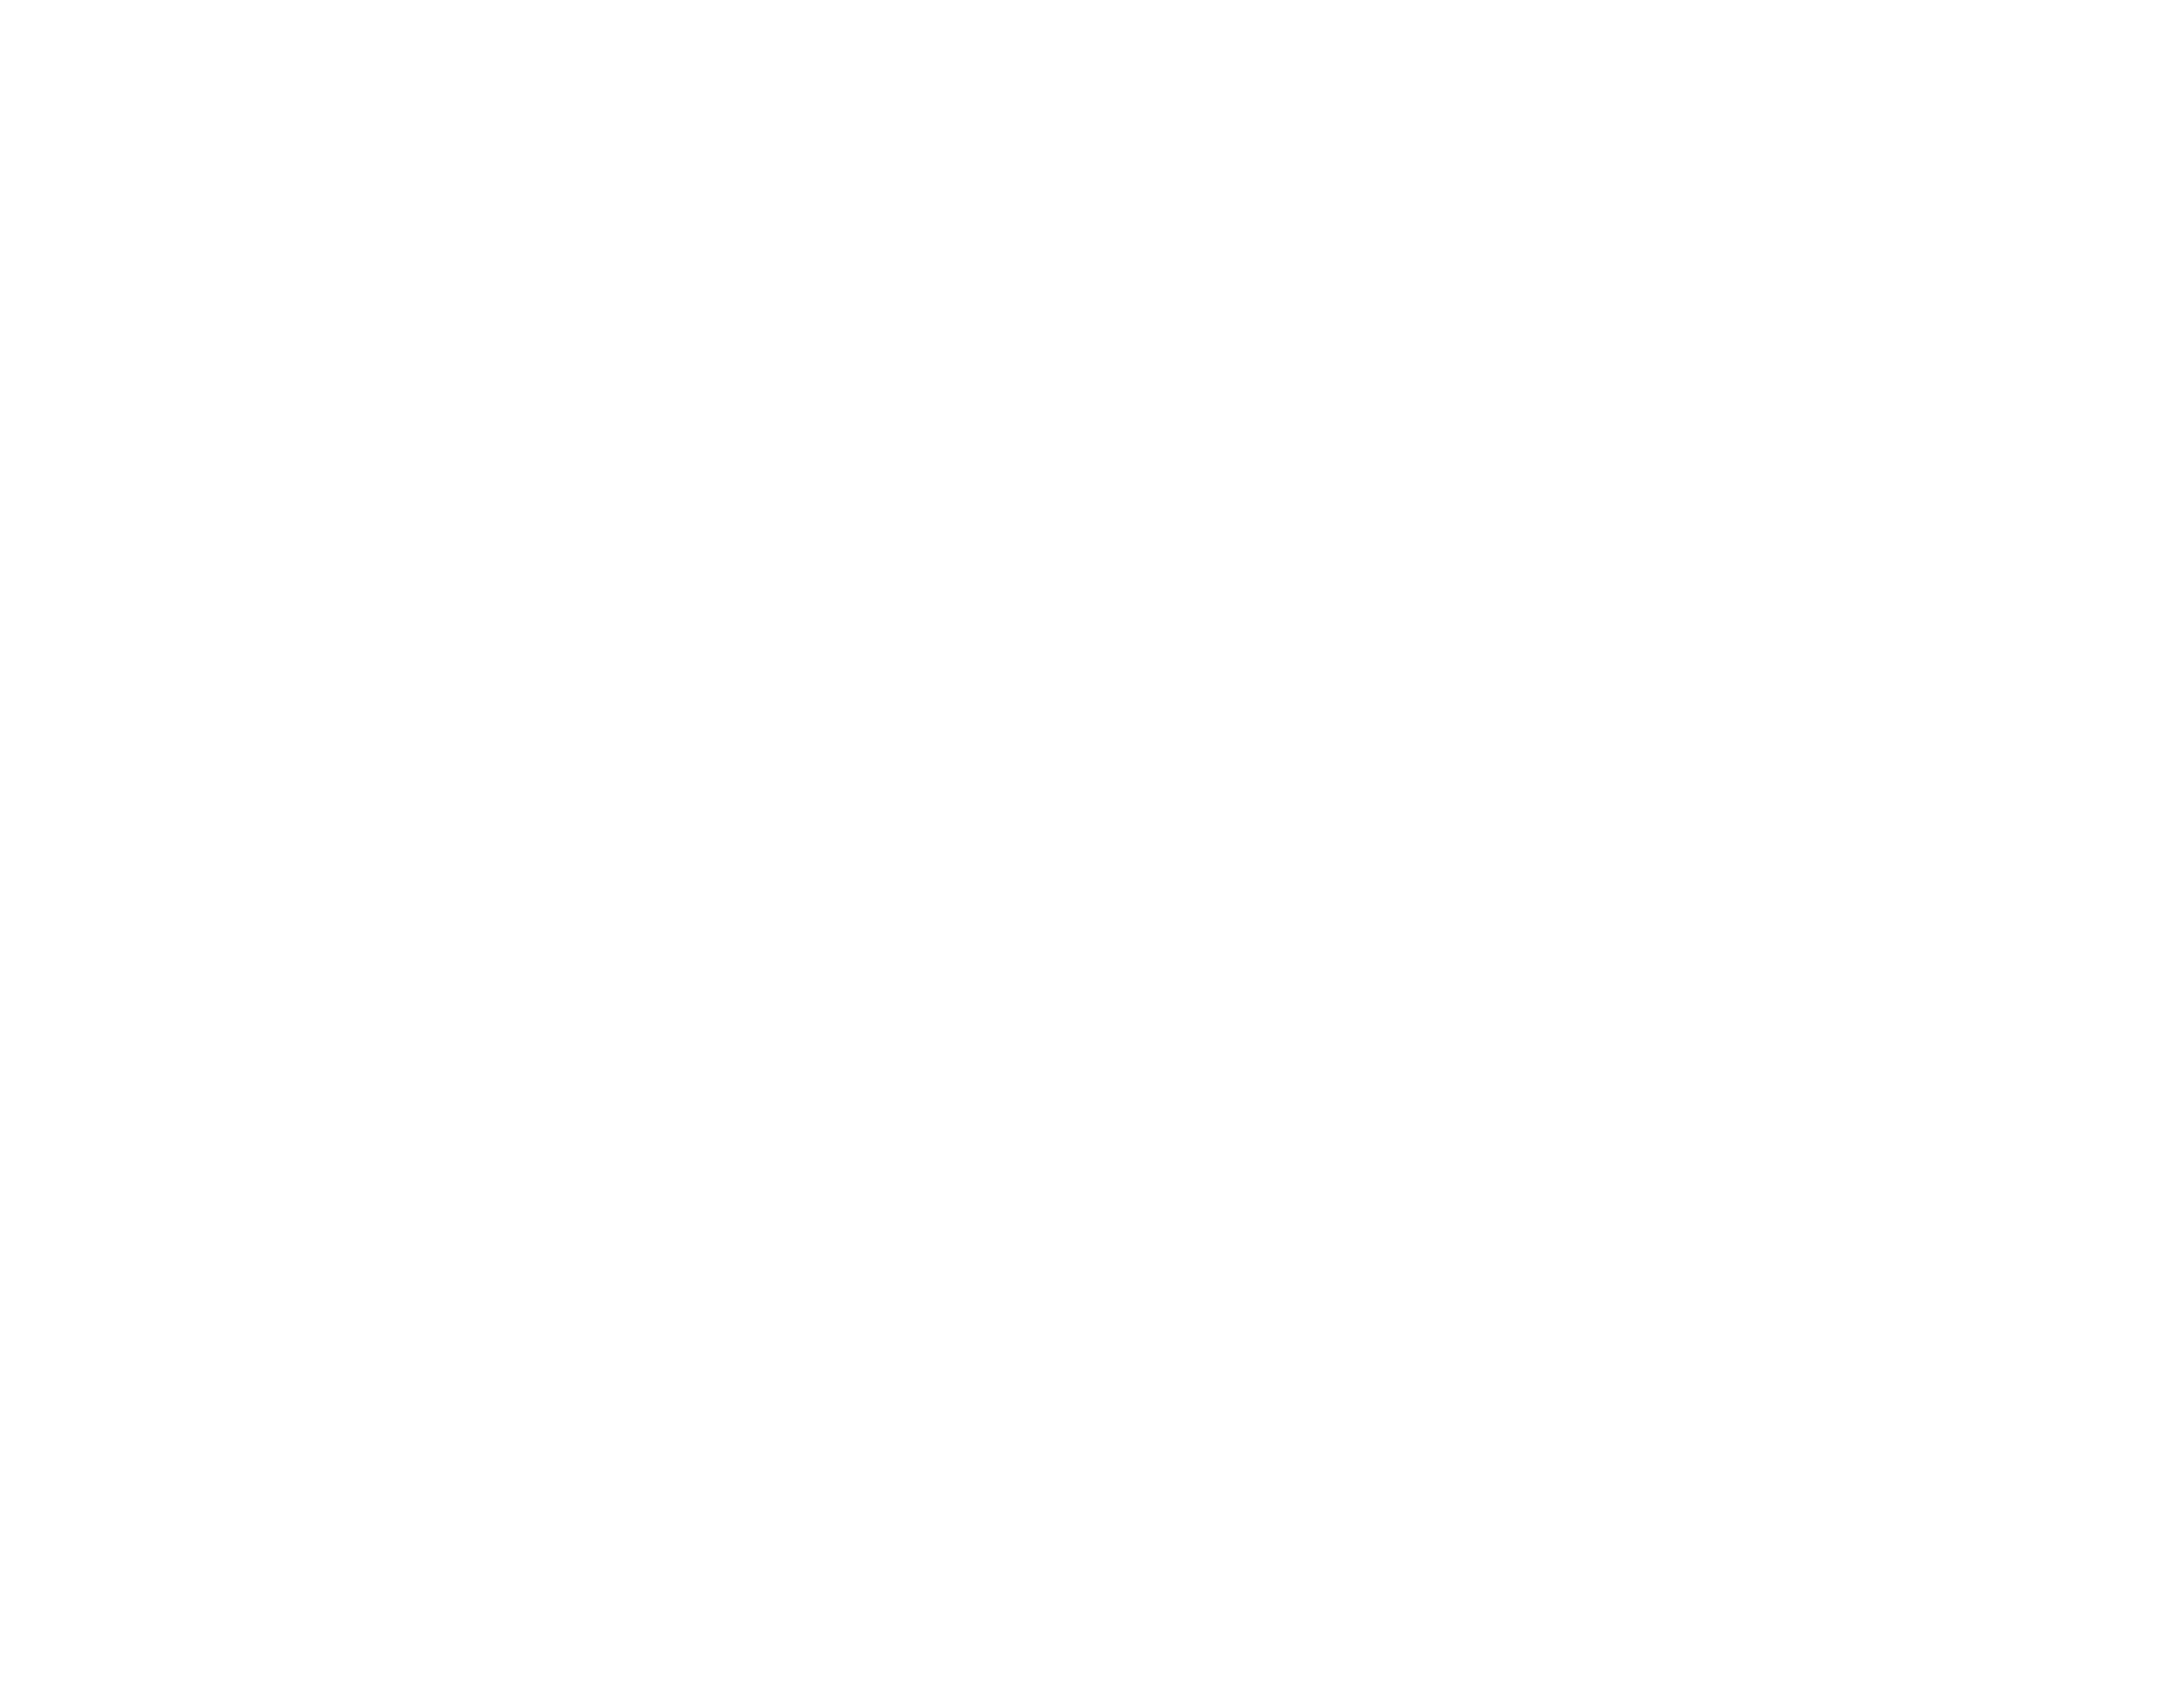

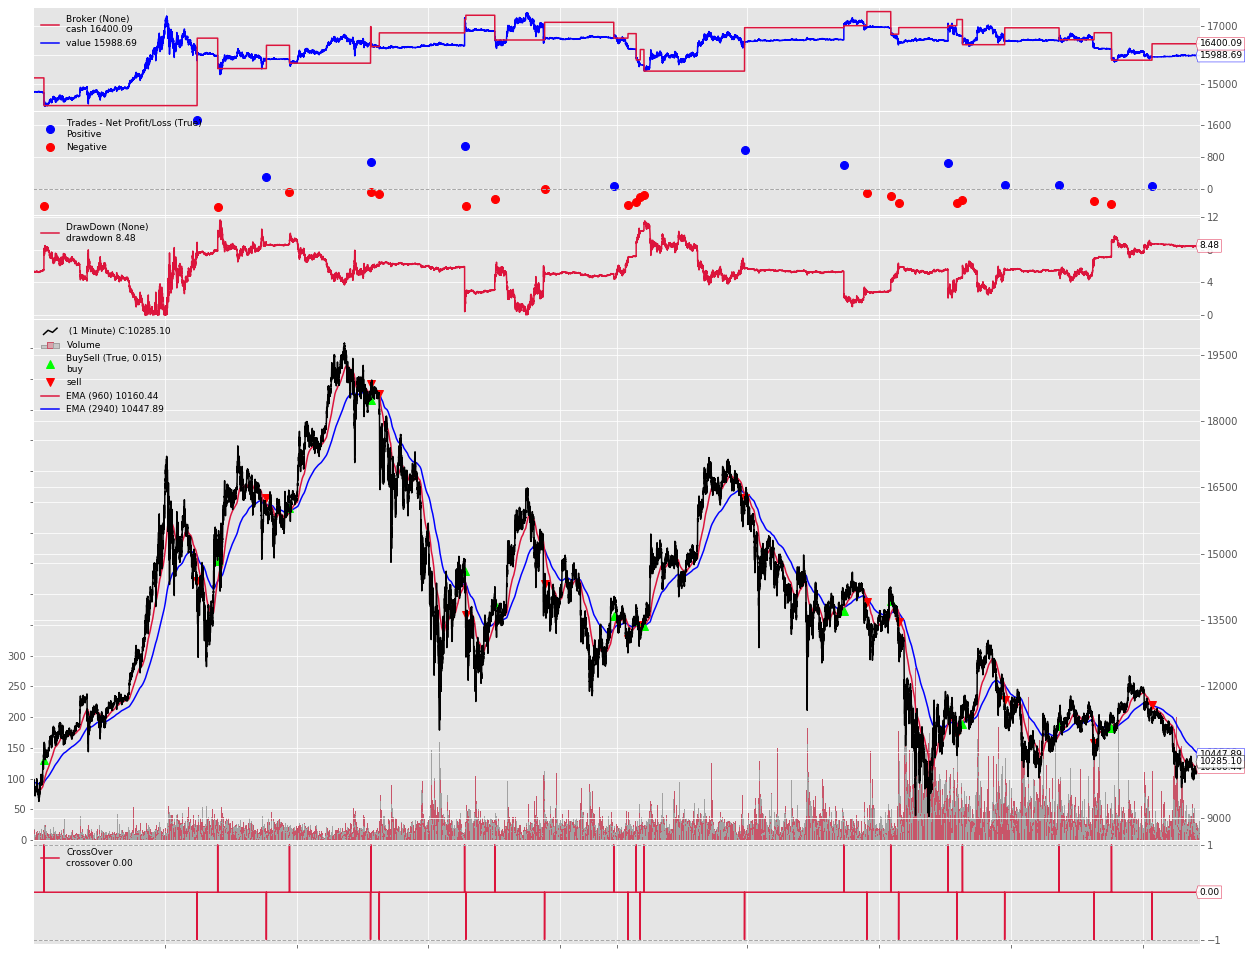

In [25]:
# Backtest with optimised parameters for simple EMA crossover on BTC / USDT

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 960),
        ('long_ema', 2940),
        ('mult', 10),  # multiply profits and loses (margin trading)
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=btc_usdt1m,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=1)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', ((cerebro.broker.getvalue() / 10000) ** 0.5 - 1) * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 2, 1))
    
    # cerebro.plot()  # plot backtest

# The End